## Deep Learning Model - GRU Multi-Label Text Classification
### Universal Sentence Encoder for Main Themes

In [30]:
import tensorflow as tf
import tensorflow_hub as hub

from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import spacy

import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss
from sklearn.metrics import precision_recall_curve
import altair as alt
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# from preprocess import Preprocessing
import sys
sys.path.append('../src/data/')
from preprocess import Preprocessing

### Loading Data

In [3]:
X_train = pd.read_excel('../data/interim/question1_models/X_train.xlsx')
X_valid = pd.read_excel('../data/interim/question1_models/X_valid.xlsx')

y_train = pd.read_excel('../data/interim/question1_models/y_train.xlsx')
y_valid = pd.read_excel('../data/interim/question1_models/y_valid.xlsx')

In [4]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((20330, 1), (5083, 1), (20330, 75), (5083, 75))

### Creating a Unified Dataframe for CNN Ready Model

In [5]:
data_df = pd.concat([X_train, y_train.iloc[:,0:12]], axis = 1)

In [6]:
data_df.head()

,Comment,CPD,CB,EWC,Exec,FEW,SP,RE,Sup,SW,TEPE,VMG,OTH
0,It is imperative that Court Services remain fo...,0,0,0,0,0,0,0,0,1,0,1,0
1,provide more competitive salary to lower the t...,0,1,0,0,0,0,0,0,0,0,0,0
2,Too much micro managing by senior management f...,0,0,0,1,0,0,0,0,0,0,0,0
3,"Being with BC govt/CTAB for less than 2 yrs, m...",0,0,0,0,0,0,0,0,0,0,0,1
4,"My organization lacks leadership, resulting in...",0,0,0,1,0,0,1,1,0,0,0,0


In [7]:
data_df.shape

(20330, 13)

> Note: The last theme `Unrelated` is not used. 

### Pre-processing

Using the function `anomymize` for using USE embeddings as we want to pass in the original text without any privacy information.

In [10]:
data_df['preprocessed_comments'] = Preprocessing().anonymize(data_df['Comment'])


In [11]:
data_df.head()

,Comment,CPD,CB,EWC,Exec,FEW,SP,RE,Sup,SW,TEPE,VMG,OTH,preprocessed_comments
0,It is imperative that Court Services remain fo...,0,0,0,0,0,0,0,0,1,0,1,0,it is imperative that court services remain fo...
1,provide more competitive salary to lower the t...,0,1,0,0,0,0,0,0,0,0,0,0,provide more competitive salary to lower the t...
2,Too much micro managing by senior management f...,0,0,0,1,0,0,0,0,0,0,0,0,too much micro managing by senior management f...
3,"Being with BC govt/CTAB for less than 2 yrs, m...",0,0,0,0,0,0,0,0,0,0,0,1,"being with bc govt/ ctab for less than 2 yrs, ..."
4,"My organization lacks leadership, resulting in...",0,0,0,1,0,0,1,1,0,0,0,0,"my organization lacks leadership, resulting in..."


In [ ]:
#preprocessed_train = Preprocessing().anonymize(data_df['Comment'])
#preprocessed_valid = Preprocessing().anonymize(X_valid['Comment'])

### Splitting into Train and Test

In [12]:
X_train = data_df[['preprocessed_comments']]
y_train = data_df.drop(['Comment', 'preprocessed_comments'], axis=1)

### Preparing Labels

**Max length of sentence**

In [16]:
def max_len(x):
    a=x.split()
    return len(a)

max_len = max(data_df['Comment'].apply(max_len))
max_len

432

### Vocab Size

In [18]:
vect=Tokenizer()
vect.fit_on_texts(X_train['preprocessed_comments'])
vocab_size = len(vect.word_index) + 1
print(vocab_size)

16815


# USE with BiGru

In [7]:
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
hub_layer = hub.KerasLayer(model, output_shape=[512], input_shape=[], dtype=tf.string, trainable=True) 

In [16]:
epochs = 3
batch_size = 128
embed_size = 512 # for universal sentence encoder
n_class = 12

In [17]:
input = tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string)
x = hub_layer(input)
x = tf.keras.layers.Reshape(input_shape=(512,), target_shape=(512, 1))(x)
bi_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(278, return_sequences=True))(x) ## changed from 125
global_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_gru)
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_gru)
concat_layer = tf.keras.layers.Concatenate()([global_pool, avg_pool])

output = tf.keras.layers.Dense(n_class, activation='sigmoid')(concat_layer)
model = tf.keras.models.Model(input, output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   Input[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 512, 1)       0           keras_layer[1][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 512, 556)     468708      reshape_1[0][0]                  
____________________________________________________________________________________________

In [18]:
X_train_array = np.asarray(X_train['preprocessed_comments'])

In [19]:
y_train_array = np.asarray(y_train)

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

# Train Model
history = model.fit(X_train_array, y_train_array, batch_size=batch_size, epochs=epochs,
          validation_split = 0.15)
history

Epoch 1/3
135/135 [==============================] - 1597s 12s/step - loss: 0.3847 - accuracy: 0.1597 - val_loss: 0.3547 - val_accuracy: 0.1561
Epoch 2/3
135/135 [==============================] - 2152s 16s/step - loss: 0.3504 - accuracy: 0.1652 - val_loss: 0.3425 - val_accuracy: 0.1561
Epoch 3/3
135/135 [==============================] - 1879s 14s/step - loss: 0.3088 - accuracy: 0.2949 - val_loss: 0.2938 - val_accuracy: 0.3367


### Checking results for Bi-Gru

In [21]:
X_valid_array = np.asarray(Preprocessing().anonymize(X_valid['Comment']))
y_valid_array = np.asarray(y_valid.iloc[:,0:12])

In [22]:
score = model.evaluate(X_valid_array, y_valid_array)
score

159/159 [==============================] - 58s 368ms/step - loss: 0.2893 - accuracy: 0.3476


[0.2892948389053345, 0.3476293385028839]

In [27]:
pred = model.predict(X_valid_array, batch_size=batch_size, verbose=1)

# PRECISION & RECALL
predictions = pred
predictions_results = []
thresholds=[0.5, 0.6, 0.7, 0.8, 0.9] #np.arange(.5, 1, 0.1).tolist()

for val in thresholds:
    pred=predictions.copy()
    pred[pred>=val]=1
    pred[pred<val]=0

    accuracy = accuracy_score(y_valid_array, pred, normalize=True, sample_weight=None)#average='micro')
    hamming = hamming_loss(y_valid_array, pred)
    precision = precision_score(y_valid_array, pred, average='micro')
    recall = recall_score(y_valid_array, pred, average='micro')
    f1 = f1_score(y_valid_array, pred, average='micro')

    case= {'Threshold': val,
           'Accuracy': accuracy,
           'Hamming loss': hamming,
           'Precision': precision,
           'Recall': recall,
           'F1-measure': f1}
    predictions_results.append(case)
print("Results on y prediction:")
pd.DataFrame(predictions_results)

40/40 [==============================] - 35s 865ms/step
Results on y prediction:


,Threshold,Accuracy,Hamming loss,Precision,Recall,F1-measure
0,0.5,0.149715,0.104482,0.858940,0.133296,0.230779
1,0.6,0.145583,0.104466,0.876648,0.129810,0.226136
2,0.7,0.142632,0.104499,0.895833,0.125906,0.220782
3,0.8,0.140075,0.104761,0.913319,0.120468,0.212860
4,0.9,0.126894,0.106236,0.932500,0.104016,0.187155


In [31]:
## Precision-Recall Curve

precision = dict()
recall = dict()
thresh = dict()
precision["micro_gru_fasttext"], recall["micro_gru_fasttext"], thresh["micro_gru_fasttext"] = precision_recall_curve(y_valid_array.ravel(),
    pred.ravel())

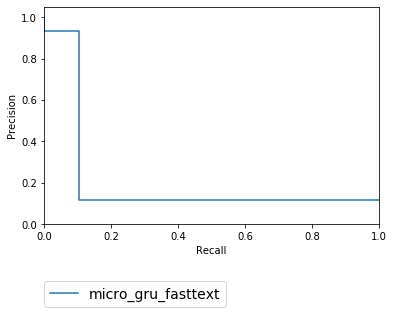

In [32]:
import matplotlib.pyplot as plt

labels = []
labels = list(precision.keys())

plt.figure()
plt.step(recall['micro_gru_fasttext'], precision['micro_gru_fasttext'], where='post')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(labels, loc=(0, -.38), prop=dict(size=14))